In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

# 山東資料整合

In [2]:
df1 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-山東1.xls')
df2 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-山東2.xls')
df3 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-山東3.xls')
df4 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-山東4.xls')
df5 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-山東5.xls')
df6 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-山東6.xls')
df7 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-山東7.xls')
df8 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-山東8.xls')
df9 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-山東9.xls')
df10 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-山東10.xls')
df11 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-山東11.xls')

patent_df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11],ignore_index=True,sort=True)

In [4]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)

firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_gd = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'37\d{10}')==True]
firm_gd = firm_gd.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_gd['區域代碼_str'] = firm_gd['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_gd = pd.merge(firm_gd,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_gd['名稱'].fillna('',inplace=True)
firm_gd['市級'].fillna('',inplace=True)
firm_gd['省份'].fillna('',inplace=True)
firm_gd['地址'].fillna('',inplace=True)
firm_gd['地址'] = firm_gd['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd['省份']+firm_gd['市級']+firm_gd['名稱']+firm_gd['地址']
firm_gd.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_gd.dropna(subset=['企業名稱'],inplace=True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,3,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
patent_df_firm = patent_df_firm[patent_df_firm['申请日']>datetime.datetime.strptime('2007-12-31','%Y-%m-%d')]
incoPat = list(patent_df_firm['申请人'])

In [5]:
patent_df_firm.shape

(15353, 38)

In [6]:
firm_gd.shape

(35597, 6)

In [ ]:
firm_gd['name_模糊比對'] = firm_gd['企業名稱'].map(lambda x:fuzzy(incoPat,x))

In [7]:
firm_gd.to_excel(r'E:\paper\清理結果-新型&授權\山東_廠商.xlsx')

# 非模糊比對

In [8]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)

(4690, 44)
(46261, 44)


In [9]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df[merge_df['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

D:\Anaconda\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(11849, 49)
(34381, 49)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

In [10]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新型&授權\山東_結果.xlsx')

# merge舊資料

In [5]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df = merge_df[merge_df['address']!='']
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(1982, 44)
(38842, 44)
(7400, 49)
(38842, 49)


In [6]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\山東_結果.xlsx')
done_data.columns

Index(['Unnamed: 0', '法人代碼', '企業名稱', '地址', '區域代碼', '行業代碼', '區域代碼_str', 'CPC',
       'IPC', 'inpadoc同族', 'inpadoc同族个数', '专利寿命（月）', '专利类型', '中国申请人区县',
       '中国申请人地市', '优先权信息', '公开国别', '公开（公告）号', '公开（公告）日', '发明人', '合享价值度',
       '同族国家', '失效日', '序号', '引证专利', '引证科技文献', '扩展同族', '扩展同族个数', '文献页数',
       '权利要求数量', '标准化申请人', '标题', '申请人', '申请人国别代码', '申请人地址', '申请人省市代码', '申请人类型',
       '申请号', '申请日', '简单同族', '简单同族个数', '被引证专利', '被引证国别(forward)', '被引证次数',
       '链接到incoPat', 'name', 'address', '完整地址', 'lat', 'lnt', '濟南', '威海火炬',
       '青島', '濰坊', '淄博', '濟寧', '煙台', '臨沂', '泰安', '專利數', '早期園區', '近期園區'],
      dtype='object')

In [7]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','濟南','威海火炬','青島','濰坊','淄博','濟寧','煙台','臨沂','泰安','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(12185, 61)

In [8]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\山東_結果.xlsx')

# 模糊比對

In [ ]:
merge_df_fuzzy = firm_gd.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)
print(merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape)
print(merge_df_fuzzy.shape)

In [ ]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0
print(merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape)
print(merge_df_fuzzy_clean.shape)

In [ ]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\山東_模糊結果.xlsx')

# 定位

In [2]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\山東_結果.xlsx',index_col=0)

In [4]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\山東_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(12185, 61)

In [5]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [8]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(38844, 61)
(569, 61)


In [7]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\山東_結果.xlsx')

# 作圖

In [9]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [10]:
patent_count.sort_values()

申请人2
龚魁杰                1
荏原冷熱システム株式会社       1
荐世春                1
荣 伟                1
荣 进                1
                ... 
青岛海信电器股份有限公司    2135
中国石油大学(华东)      2299
山东科技大学          5584
山东大学            5791
海尔集团公司          5931
Name: 專利數, Length: 142622, dtype: int64

In [ ]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\山東_結果.xlsx',index_col=0)
target1 = (36.68008,117.11706)
merge_df['濟南'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
target2 = (37.50861,122.03625)
merge_df['威海火炬'] = merge_df.apply(lambda x:how_far(target2,(x['lat'],x['lnt'])),axis=1)
target3 = (36.26636,120.27788)
merge_df['青島'] = merge_df.apply(lambda x:how_far(target3,(x['lat'],x['lnt'])),axis=1)
target4 = (36.65236,119.16199)
merge_df['濰坊'] = merge_df.apply(lambda x:how_far(target4,(x['lat'],x['lnt'])),axis=1)
target5 = (36.84739,118.04303)
merge_df['淄博'] = merge_df.apply(lambda x:how_far(target5,(x['lat'],x['lnt'])),axis=1)
target6 = (35.4244,116.61995)
merge_df['濟寧'] = merge_df.apply(lambda x:how_far(target6,(x['lat'],x['lnt'])),axis=1)
target7 = (37.42215,121.52786)
merge_df['煙台'] = merge_df.apply(lambda x:how_far(target7,(x['lat'],x['lnt'])),axis=1)
target8 = (34.98569,118.26425)
merge_df['臨沂'] = merge_df.apply(lambda x:how_far(target8,(x['lat'],x['lnt'])),axis=1)
target9 = (36.20249,117.17753)
merge_df['泰安'] = merge_df.apply(lambda x:how_far(target9,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [11]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\山東_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)

In [12]:
target1 = (36.68008,117.11706)
target2 = (37.50861,122.03625)
target3 = (36.26636,120.27788)
target4 = (36.65236,119.16199)
target5 = (36.84739,118.04303)
target6 = (35.4244,116.61995)
target7 = (37.42215,121.52786)
target8 = (34.98569,118.26425)
target9 = (36.20249,117.17753)

for i in merge_df[merge_df['濟南']==''].index:
    merge_df.loc[i,'濟南'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'威海火炬'] = how_far(target2,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'青島'] = how_far(target3,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'濰坊'] = how_far(target4,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'淄博'] = how_far(target5,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'濟寧'] = how_far(target6,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'煙台'] = how_far(target7,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'臨沂'] = how_far(target8,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'泰安'] = how_far(target9,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [13]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if ((x['濟南']<10)or(x['威海火炬']<10)or(x['青島']<10)or(x['濰坊']<10)or(x['淄博']<10)) else 0,axis=1)
merge_df['近期園區'] = merge_df.apply(lambda x:1 if ((x['濟寧']<10)or(x['煙台']<10)or(x['臨沂']<10)or(x['泰安']<10)) else 0,axis=1)

In [14]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\山東_結果.xlsx')

In [15]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

(38844, 61)
0.7766965297085779
0.00455668829162805


In [16]:
merge_df.groupby('專利數')['IPC'].count()

專利數
0.0       30170
1.0        1661
2.0         916
3.0         651
4.0         505
5.0         378
6.0         431
7.0         425
8.0         404
9.0         269
10.0        288
11.0        214
12.0        265
13.0        165
14.0        172
15.0        154
16.0        127
17.0        124
18.0         82
19.0        101
20.0         82
21.0         71
22.0         73
23.0         45
24.0         64
25.0         49
26.0         46
27.0         41
28.0         38
29.0         39
30.0         31
31.0         21
32.0         32
33.0         19
34.0         30
35.0         20
36.0         17
37.0         19
38.0         19
39.0         23
40.0         10
41.0         21
42.0         21
43.0         10
44.0         20
45.0         14
46.0          8
47.0         14
48.0         13
49.0          9
50.0         11
51.0         12
52.0         10
53.0         11
54.0         13
55.0          8
56.0          9
57.0          9
58.0          7
59.0         10
60.0          6
61.0          9
62.0

In [17]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

專利數
0.0     483
1.0      16
2.0      14
3.0       6
4.0       6
5.0       6
6.0       4
7.0       1
8.0       3
9.0       3
10.0      1
11.0      3
12.0      4
13.0      3
15.0      2
17.0      2
20.0      1
21.0      2
24.0      1
27.0      1
28.0      3
30.0      2
33.0      1
77.0      1
Name: IPC, dtype: int64

Text(0, 0.5, '無法定位廠商數量')

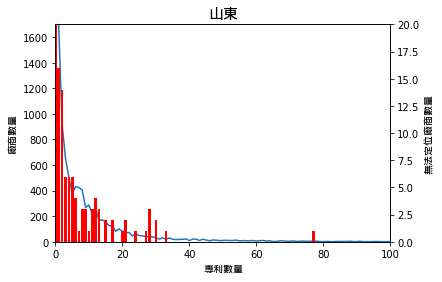

In [19]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('山東',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,1700])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,20])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)


In [7]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\山東_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','公司','责任','集团','股份','控股','总公司','分公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

3056
0.08023945806858163
72


In [9]:
not_merge.groupby('專利數')['IPC'].count()

專利數
1       747
2       365
3       252
4       210
5       145
6       105
7       127
8        84
9        82
10       70
11       59
12       79
13       50
14       46
15       36
16       34
17       39
18       25
19       31
20       21
21       25
22       20
23       11
24       20
25       15
26       12
27       11
28       13
29       16
30        8
31        9
32       12
33        8
34        9
35        7
36        6
37        7
38        6
39       12
40        1
41       11
42        8
43        4
44        9
45        3
46        5
47        4
48        5
49        2
50        5
51        5
52        4
53        4
54        5
55        1
56        2
57        2
58        2
59        4
60        2
61        4
62        3
63        6
64        3
65        1
66        3
67        1
68        3
69        3
70        2
71        1
72        1
73        1
74        1
75        1
76        2
77        2
78        2
79        2
81        1
84        1
85        2
88        2


In [10]:
not_merge[not_merge['專利數']>=1000].sort_values('專利數')

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str,CPC,IPC,inpadoc同族,inpadoc同族个数,专利寿命（月）,专利类型,中国申请人区县,中国申请人地市,优先权信息,公开国别,公开（公告）号,公开（公告）日,发明人,合享价值度,同族国家,失效日,序号,引证专利,引证科技文献,...,简单同族,简单同族个数,被引证专利,被引证国别(forward),被引证次数,链接到incoPat,申请人,name,address,完整地址,lat,lnt,濟南,威海火炬,青島,濰坊,淄博,濟寧,煙台,臨沂,泰安,早期園區,近期園區,專利數,name_clean
36200,,,,,,,,F25D25/00,CN101221008A; CN100520254C,2,0,发明授权,[崂山],[青岛],,CN,CN100520254C,2009-07-29 00:00:00,赵明华; 高丽霞; 马杰; 孙福,9,CN,,3390,CN2407305Y; US20050160854A1; JP03225188A; CA2492681A1; WO2007007950A1; CN1305763A,,...,CN101221008A; CN100520254C,2,,,0,到incoPat中查看\r\nCN100520254C,青岛海尔股份有限公司,青岛海尔股份有限公司,山东省青岛市海尔路1号海尔信息园,1,36.1334,120.43,303.248026,209.363589,20.099695,127.475816,228.044862,353.297518,173.387422,233.994375,292.688947,0,0,1101,青岛海尔
38333,,,,,,,,B66D1/74; B66D1/08; F15B11/17,CN102976224A; CN102976224B,2,60,发明授权,[市中],[济南],,CN,CN102976224B,2014-09-10 00:00:00,刘福云; 吕兴润,5,CN,2017-12-19 00:00:00,29579,,,...,CN102976224B; CN102976224A,2,,,0,View in incopat\r\nCN102976224B,中国重汽集团济南动力有限公司,中国重汽集团济南动力有限公司,山东省济南市市中区英雄山路65号,1,36.6119,117.005,12.554851,458.355144,295.930587,192.966954,96.334299,136.261614,412.373540,213.336963,47.997418,0,0,1706,中国重汽济南动力
38494,,,,,,,,G06F21/70,CN103020545B; CN103020545A,2,,发明授权,[历下],[济南],,CN,CN103020545B,2016-03-02 00:00:00,井立财; 李博乐,9,CN,,23123,CN1828548A; CN1851611A; CN1855062A; US20060284915A1,,...,CN103020545B; CN103020545A,2,,,0,View in incopat\r\nCN103020545B,浪潮电子信息产业股份有限公司,浪潮电子信息产业股份有限公司,山东省济南市高新区舜雅路1036号,1,36.6815,117.127,0.939655,445.889693,286.068441,181.913229,83.796851,146.794941,399.919668,214.370485,53.349068,1,0,1822,浪潮电子信息产业
38458,,,,,,,,H04N21/458; G06F17/30,CN103024555B; CN103024555A,2,,发明授权,[黄岛],[青岛],,CN,CN103024555B,2015-08-26 00:00:00,路玉太,9,CN,,32830,CN101026721A; CN1937723A; CN102523500A; WO2010093189A2,,...,CN103024555A; CN103024555B,2,,,0,View in incopat\r\nCN103024555B,青岛海信电器股份有限公司,青岛海信电器股份有限公司,山东省青岛市经济技术开发区前湾港路218号,1,35.9984,120.162,283.601853,236.850792,31.511749,115.432180,212.074913,326.752693,199.641528,205.594244,269.672649,0,0,2135,青岛海信电器


Text(0.5, 0, '專利數量')

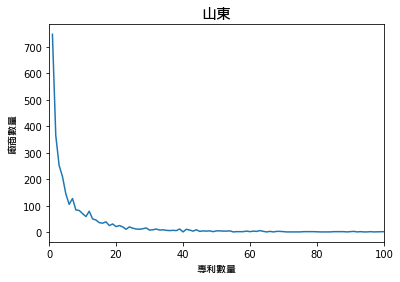

In [12]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('山東',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [11]:
cleaned.to_excel(r'E:\paper\名稱merge\山東_結果.xlsx')

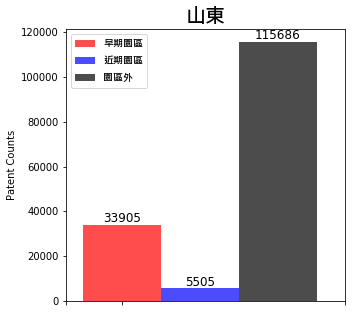

In [9]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('山東',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper left',prop=myfont)

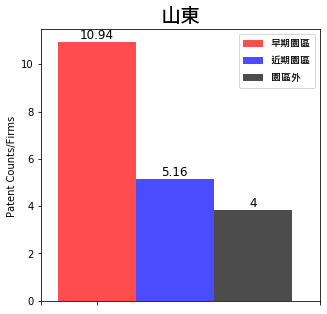

In [10]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.0f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('山東',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)